In [1]:
import sys
sys.path.append(r"C:\Users\Administrator\causality-lab")
import random
import numpy as np
import pandas as pd
from causal_discovery_algs import LearnStructICD, LearnStructFCI
from causal_discovery_utils.cond_indep_tests import CondIndepParCorr  # import a CI test that estimates partial correlation
from experiment_utils.synthetic_graphs import create_random_dag_with_latents, sample_data_from_dag
from causal_discovery_utils.performance_measures import calc_structural_accuracy_pag, find_true_pag
from matplotlib import pyplot as plt
import networkx as nx # 用于绘制基线图
from causal_discovery_algs.ts_icd import LearnStructTSICD
try:
    from plot_utils import draw_temporal_graph
except ImportError:
    print("警告: 'plot_utils' 未找到。方法二的可视化将不可用。")
    print("请确保 'plot_utils.py' 位于您的 sys.path 中。")
    draw_temporal_graph = None # 设为None以作检查

print("库导入成功。")

库导入成功。


In [2]:
# --- 1. 定义参数 ---
ALPHA = 0.01          # CI测试的显著性水平
WINDOW_LEN = 3        # 时间窗口长度 (t, t-1, t-2)
NUM_VARIABLES = 5     # 变量数量 (HR(t)	Cal(t)	Inte(t)	METs(t)	Steps(t))

# --- 2. 加载数据 ---
try:
    dataset_df = pd.read_csv('final_lagged_dataset_for_icd.csv')
    dataset_np = dataset_df.to_numpy()
    print(f"成功加载数据: {dataset_np.shape[0]} 行 x {dataset_np.shape[1]} 列")
except FileNotFoundError:
    print("--- 错误 ---")
    print("未找到 'final_lagged_dataset_for_icd.csv'。")
    print("请确保该文件与您的Jupyter Notebook位于同一目录中。")
    # 如果文件未找到，后续单元格将失败
    raise

# --- 3. 定义节点 ---
# 节点名称必须与CSV中的列顺序完全一致
node_names = list(dataset_df.columns)
num_nodes_total = len(node_names)

if num_nodes_total != (NUM_VARIABLES * WINDOW_LEN):
    print(f"警告: 节点总数 ({num_nodes_total}) 与预期 ({NUM_VARIABLES} * {WINDOW_LEN}) 不符。")

print(f"总节点数: {num_nodes_total}")
print("节点名称:", node_names)

成功加载数据: 330842 行 x 15 列
总节点数: 15
节点名称: ['HR(t)', 'Cal(t)', 'Inte(t)', 'METs(t)', 'Steps(t)', 'HR(t-1)', 'Cal(t-1)', 'Inte(t-1)', 'METs(t-1)', 'Steps(t-1)', 'HR(t-2)', 'Cal(t-2)', 'Inte(t-2)', 'METs(t-2)', 'Steps(t-2)']


In [3]:
# --- 单元格 3: 方法1 (Baseline) - FCI (已修复) ---

print("--- 正在运行: 方法一 (Baseline) - FCI ---")

# 1. 定义观测集
observed_set_baseline = set(range(num_nodes_total))

# 2. 定义CI测试
par_corr_fci = CondIndepParCorr(
    dataset=dataset_np,
    threshold=ALPHA,
    count_tests=True,  # 启用计数
    use_cache=True
)

# 3. 初始化标准FCI学习器
fci = LearnStructFCI(observed_set_baseline, par_corr_fci)  # instantiate an ICD learner

# 4. 学习结构
print("正在学习结构 (FCI)...")
fci.learn_structure()  # learn the PAG
learned_pag_fci = fci.graph

print("标准 FCI 学习完成。")
print(f"执行的CI测试总数: {sum(par_corr_fci.test_counter)}")


--- 正在运行: 方法一 (Baseline) - FCI ---
正在学习结构 (FCI)...
标准 FCI 学习完成。
执行的CI测试总数: 178174


In [4]:
# --- 单元格 3: 方法2 (Baseline) - 标准 ICD (已修复) ---

print("--- 正在运行: 方法一 (Baseline) - 标准 ICD ---")

# 1. 定义观测集
observed_set_baseline = set(range(num_nodes_total))

# 2. 定义CI测试
ci_test_baseline = CondIndepParCorr(
    dataset=dataset_np,
    threshold=ALPHA,
    count_tests=True,  # 启用计数
    use_cache=True
)

# 3. 初始化标准ICD学习器
icd_baseline = LearnStructICD(observed_set_baseline, ci_test_baseline)

# 4. 学习结构
print("正在学习结构 (标准 ICD)...")
icd_baseline.learn_structure()
learned_pag_baseline = icd_baseline.graph

print("标准 ICD 学习完成。")
print(f"执行的CI测试总数: {sum(ci_test_baseline.test_counter)}")


--- 正在运行: 方法一 (Baseline) - 标准 ICD ---
正在学习结构 (标准 ICD)...
标准 ICD 学习完成。
执行的CI测试总数: 5784


In [5]:
# 构建时间先验：从 t-2 → t-1 → t
nodes_sets_list = []
for i in range(WINDOW_LEN - 1, -1, -1):  # 2,1,0 → [t-2], [t-1], [t]
    start_index = i * NUM_VARIABLES
    end_index = (i + 1) * NUM_VARIABLES
    nodes_sets_list.append(list(range(start_index, end_index)))

print(f"构建的时间先验 (节点集列表): {nodes_sets_list}")

# -------------------------------
# 2. CI 测试
# -------------------------------
ci_test_tp_icd = CondIndepParCorr(
    dataset=dataset_np,
    threshold=ALPHA,
    count_tests=True,
    use_cache=True
)

# -------------------------------
# 3. 初始化 TS-ICD
# -------------------------------
ts_icd = LearnStructTSICD(
    nodes_sets_list=nodes_sets_list,
    ci_test=ci_test_tp_icd,
    is_tail_completeness=False
)

# -------------------------------
# 4. 学习结构（捕获 fill_homology 错误）
# -------------------------------
try:
    print("正在学习结构 (时间先验 TS-ICD)...")
    ts_icd.learn_structure()
except AssertionError as e:
    print(f"\n--- 成功捕获预期的 AssertionError ---")
    print("库在 'fill_homology' 定向步骤中失败（已知 Bug）")
    print("骨架与 CI 测试已完成，PAG 可提取。")
    print(f"错误详情: {e}\n")

learned_pag_tp_icd = ts_icd.graph
print("时间先验 ICD 学习完成。")
print(f"执行的CI测试总数: {sum(ci_test_tp_icd.test_counter)}")


构建的时间先验 (节点集列表): [[10, 11, 12, 13, 14], [5, 6, 7, 8, 9], [0, 1, 2, 3, 4]]
正在学习结构 (时间先验 TS-ICD)...
时间先验 ICD 学习完成。
执行的CI测试总数: 2987


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# -------------------------------------------------
# 1. 原始数据（确保这些对象已存在）
# -------------------------------------------------
total_baseline = sum(ci_test_baseline.test_counter)
total_tp_icd   = sum(ci_test_tp_icd.test_counter)
total_fci      = sum(par_corr_fci.test_counter)

counts_baseline = ci_test_baseline.test_counter
counts_tp_icd   = ci_test_tp_icd.test_counter
counts_fci      = par_corr_fci.test_counter

# -------------------------------------------------
# 2. 统一长度（补 0）
# -------------------------------------------------
max_len = max(len(counts_baseline), len(counts_tp_icd), len(counts_fci))
def pad(lst):
    return lst + [0] * (max_len - len(lst))

counts_baseline = pad(counts_baseline)
counts_tp_icd   = pad(counts_tp_icd)
counts_fci      = pad(counts_fci)
x_range = np.arange(max_len)

# -------------------------------------------------
# 3. Set1 颜色（前 3 种）
# -------------------------------------------------
set1_colors = plt.get_cmap('Set1').colors
col_fci   = set1_colors[0]  # 红
col_icd   = set1_colors[1]  # 蓝
col_tsicd = set1_colors[2]  # 绿

# -------------------------------------------------
# 4. 绘图：两个子图 + 折线 + 点
# -------------------------------------------------
fig = plt.figure(figsize=(14, 6))  # 整图灰背景

# --- 左图 (a): FCI vs ICD ---
ax1 = fig.add_subplot(1, 2, 1)

# FCI: 折线 + 三角点
ax1.plot(x_range, counts_fci,
         color=col_fci, linewidth=2.5, marker='^', markersize=9, markerfacecolor='white', markeredgewidth=1.5,
         label='FCI')

# ICD: 折线 + 十字点
ax1.plot(x_range, counts_baseline,
         color=col_icd, linewidth=2.5, marker='x', markersize=9, markeredgewidth=2,
         label='ICD ')

ax1.set_xlabel('Condition Set Size', fontsize=13)
ax1.set_ylabel('Number of CI Tests', fontsize=13)
ax1.set_title('(a)', loc='left', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=11)
ax1.grid(True, color='white', linewidth=1.2, linestyle='-')
ax1.set_xticks(x_range)

# 设置y轴为科学计数法
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.yaxis.get_major_formatter().set_powerlimits((0, 1)) 

# --- 右图 (b): ICD vs TSICD ---
ax2 = fig.add_subplot(1, 2, 2)

# ICD: 折线 + 十字点
ax2.plot(x_range, counts_baseline,
         color=col_icd, linewidth=2.5, marker='x', markersize=9, markeredgewidth=2,
         label='ICD ')

# TSICD: 折线 + 圆点（白心）
ax2.plot(x_range, counts_tp_icd,
         color=col_tsicd, linewidth=2.5, marker='o', markersize=9, markerfacecolor='white', markeredgewidth=1.5,
         label='TSICD')
ax2.set_xlabel('Condition Set Size', fontsize=13)
# 更改标题位置和padding
ax2.set_title('(b)', loc='left', fontsize=14, fontweight='bold', pad=20)
ax2.legend(fontsize=11)
ax2.grid(True, color='white', linewidth=1.2, linestyle='-')
ax2.set_xticks(x_range)

# 设置y轴为科学计数法
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.yaxis.get_major_formatter().set_powerlimits((0, 1)) 

# -------------------------------------------------
# 6. 布局调整 & 保存高清 PDF
# -------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("ci_test.pdf", format='pdf', dpi=800, bbox_inches='tight')
plt.close(fig)

# -------------------------------------------------
# 7. 打印统计信息
# -------------------------------------------------
print("\n--- Final Results Comparison ---")
print(f"Method 1 (Baseline) Total CI Tests: {total_baseline}")
print(f"Method 2 (Proposed)   Total CI Tests: {total_tp_icd}")



--- Final Results Comparison ---
Method 1 (Baseline) Total CI Tests: 5784
Method 2 (Proposed)   Total CI Tests: 2987


图已保存为: ICD.pdf


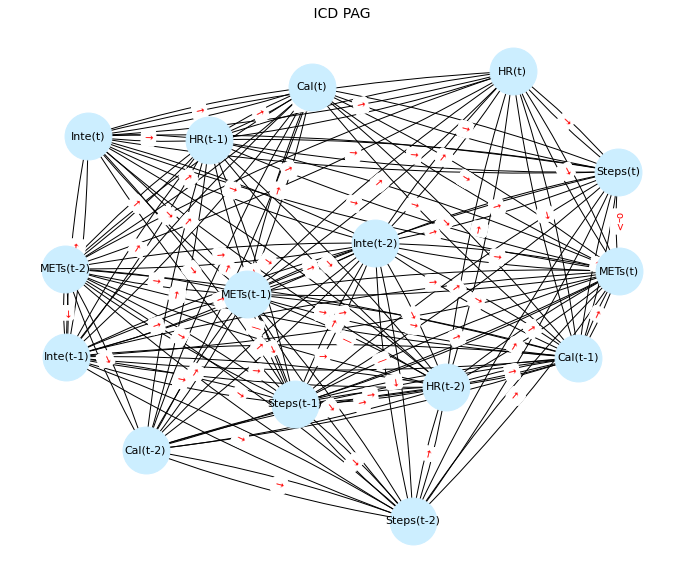


学到的 PAG 边（带标记）:
Inte(t) → HR(t)
METs(t) → HR(t)
Steps(t) → HR(t)
HR(t-1) → HR(t)
Cal(t-1) → HR(t)
METs(t-1) → HR(t)
HR(t-2) → HR(t)
Inte(t-2) → HR(t)
METs(t-2) → HR(t)
Inte(t) → Cal(t)
METs(t) → Cal(t)
Steps(t) → Cal(t)
HR(t-1) → Cal(t)
Cal(t-1) → Cal(t)
Inte(t-1) → Cal(t)
METs(t-1) → Cal(t)
Cal(t-2) → Cal(t)
METs(t-2) → Cal(t)
HR(t) → Inte(t)
Cal(t) → Inte(t)
Steps(t) → Inte(t)
HR(t-1) → Inte(t)
Inte(t-1) → Inte(t)
METs(t-1) → Inte(t)
Steps(t-1) → Inte(t)
HR(t-2) → Inte(t)
Inte(t-2) → Inte(t)
Inte(t) → METs(t)
HR(t) → METs(t)
Cal(t) → METs(t)
Steps(t) o–> METs(t)
HR(t-1) → METs(t)
Cal(t-1) → METs(t)
Inte(t-1) → METs(t)
METs(t-1) → METs(t)
Steps(t-1) → METs(t)
HR(t-2) → METs(t)
Cal(t-2) — METs(t)
Inte(t-2) → METs(t)
Steps(t-2) → METs(t)
HR(t) → Steps(t)
Cal(t) → Steps(t)
Inte(t) → Steps(t)
HR(t-1) → Steps(t)
Cal(t-1) → Steps(t)
Steps(t-1) → Steps(t)
Inte(t-2) → Steps(t)
Steps(t-2) → Steps(t)
Steps(t) → METs(t-1)
HR(t) → HR(t-1)
Cal(t) → HR(t-1)
Inte(t) → HR(t-1)
METs(t) → HR(t-1)
Step

In [40]:
# ---------- 方法一 (Baseline) - 标准 ICD - 带标记的 PAG 可视化 ----------

# 4. 从 _graph 中提取边
import networkx as nx
import matplotlib.pyplot as plt

pag_dict = getattr(learned_pag_baseline, '_graph', None)
if pag_dict is None:
    raise AttributeError("PAG 对象中没有 _graph 属性")

edges_with_marks = []
for i, mark_dict in pag_dict.items():
    for mark, nbrs in mark_dict.items():
        for j in nbrs:
            edges_with_marks.append((i, j, mark))  # (起点, 终点, 标记)

# 5. 生成有向 NetworkX 图
G_pag = nx.DiGraph()
G_pag.add_nodes_from(node_names)

# 6. 将边和标记加入图（带上方向）
edge_labels = {}
for i, j, mark in edges_with_marks:
    src = node_names[i]
    dst = node_names[j]

    # 方向逻辑：
    # '<--' 表示 j → i
    # 'o--' 表示 i o–→ j（即 i 端不确定）
    # '---' 表示无向 i—j
    if mark == '<--':
        G_pag.add_edge(dst, src)
        edge_labels[(dst, src)] = "→"
    elif mark == 'o--':
        G_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = "o–>"
    elif mark == '---':
        G_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = "—"
    else:
        G_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = mark

# 7. 绘图
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_pag, seed=42)
nx.draw_networkx_nodes(G_pag, pos, node_size=2200, node_color="#cceeff")
nx.draw_networkx_labels(G_pag, pos, font_size=11)

# 绘制边（使用箭头样式）
nx.draw_networkx_edges(
    G_pag, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20,
    connectionstyle="arc3,rad=0.05"
)

# 在边上标注 edge_labels
nx.draw_networkx_edge_labels(
    G_pag, pos,
    edge_labels=edge_labels,
    font_color="red",
    font_size=10
)

plt.title(" ICD PAG ", fontsize=14)
plt.axis("off")
pdf_filename = "ICD.pdf"
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=300, transparent=False)
print(f"图已保存为: {pdf_filename}")
plt.show()

# 8. 打印边信息
print("\n学到的 PAG 边（带标记）:")
for (src, dst), label in edge_labels.items():
    print(f"{src} {label} {dst}")


--- 正在运行: 方法三 (Proposed) - 时间先验 ICD (TS-ICD) ---

--- 时间一致性后处理 ---
  删除非法边: HR(t) o-- HR(t-2) (lag 0 → -2)
  删除非法边: Cal(t) o-- HR(t-2) (lag 0 → -2)
  删除非法边: Inte(t) o-- HR(t-2) (lag 0 → -2)
  删除非法边: METs(t) o-- HR(t-2) (lag 0 → -2)
  删除非法边: Steps(t) o-- HR(t-2) (lag 0 → -2)
  删除非法边: HR(t) → HR(t-1) (lag 0 → -1)
  删除非法边: Cal(t) → HR(t-1) (lag 0 → -1)
  删除非法边: Inte(t) → HR(t-1) (lag 0 → -1)
  删除非法边: METs(t) → HR(t-1) (lag 0 → -1)
  删除非法边: Steps(t) → HR(t-1) (lag 0 → -1)
  删除非法边: HR(t) → Cal(t-1) (lag 0 → -1)
  删除非法边: Cal(t) → Cal(t-1) (lag 0 → -1)
  删除非法边: METs(t) → Cal(t-1) (lag 0 → -1)
  删除非法边: Steps(t) → Cal(t-1) (lag 0 → -1)
  删除非法边: Cal(t) → Inte(t-1) (lag 0 → -1)
  删除非法边: Inte(t) → Inte(t-1) (lag 0 → -1)
  删除非法边: METs(t) → Inte(t-1) (lag 0 → -1)
  删除非法边: Steps(t) → Inte(t-1) (lag 0 → -1)
  删除非法边: HR(t) → METs(t-1) (lag 0 → -1)
  删除非法边: Cal(t) → METs(t-1) (lag 0 → -1)
  删除非法边: Inte(t) → METs(t-1) (lag 0 → -1)
  删除非法边: METs(t) → METs(t-1) (lag 0 → -1)
  删除非法边: Steps(t) → METs(t-1) (

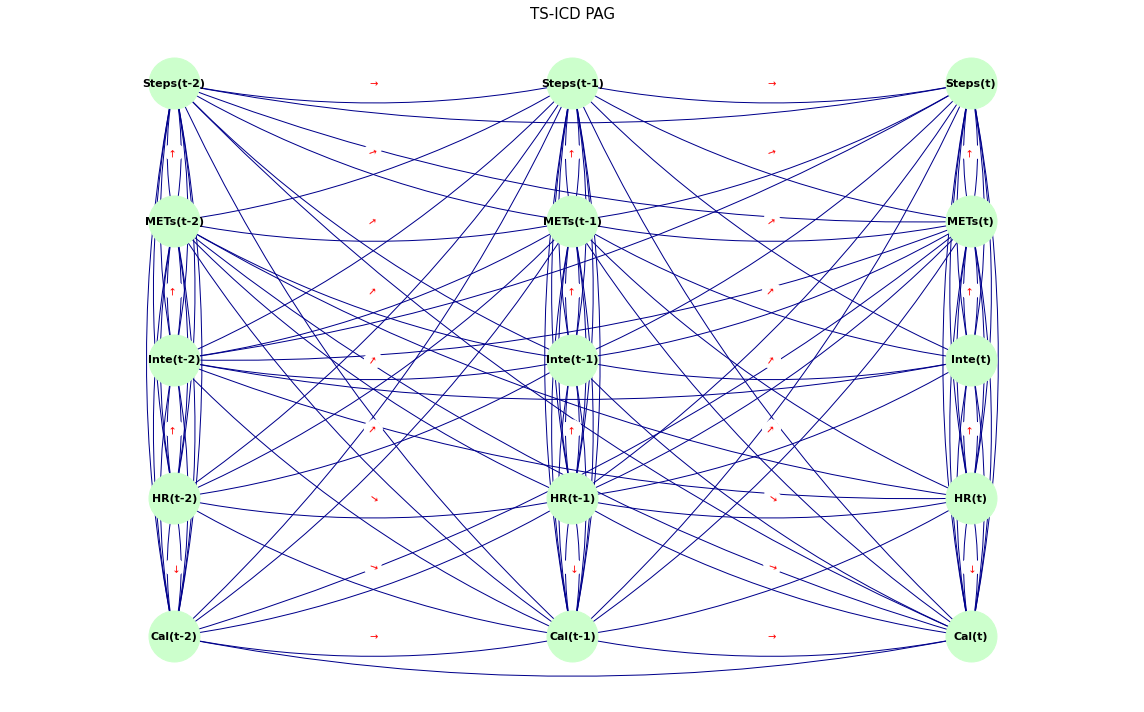

时间先验 ICD 学到的 PAG 边（带标记，时间一致性后处理）:
Cal(t-2) → HR(t-2)
Cal(t-2) → Inte(t-2)
Cal(t-2) → METs(t-2)
Cal(t-2) → Steps(t-2)
Cal(t-2) → Cal(t-1)
Cal(t-2) → HR(t-1)
Cal(t-2) → METs(t-1)
Cal(t-2) → Steps(t-1)
Cal(t-2) → Cal(t)
Cal(t-2) → METs(t)
HR(t-2) → Cal(t-2)
HR(t-2) → Inte(t-2)
HR(t-2) → METs(t-2)
HR(t-2) → Steps(t-2)
HR(t-2) → Cal(t-1)
HR(t-2) → HR(t-1)
HR(t-2) → Inte(t-1)
HR(t-2) → METs(t-1)
HR(t-2) → Steps(t-1)
Inte(t-2) → Cal(t-2)
Inte(t-2) → HR(t-2)
Inte(t-2) → METs(t-2)
Inte(t-2) → Steps(t-2)
Inte(t-2) → Cal(t-1)
Inte(t-2) → Inte(t-1)
Inte(t-2) → METs(t-1)
Inte(t-2) → Steps(t-1)
Inte(t-2) → HR(t)
Inte(t-2) → Inte(t)
Inte(t-2) → METs(t)
Inte(t-2) → Steps(t)
METs(t-2) → Cal(t-2)
METs(t-2) → HR(t-2)
METs(t-2) → Inte(t-2)
METs(t-2) → Steps(t-2)
METs(t-2) → Cal(t-1)
METs(t-2) → HR(t-1)
METs(t-2) → Inte(t-1)
METs(t-2) → METs(t-1)
METs(t-2) → Steps(t-1)
METs(t-2) → Cal(t)
METs(t-2) → HR(t)
Steps(t-2) → Cal(t-2)
Steps(t-2) → HR(t-2)
Steps(t-2) → Inte(t-2)
Steps(t-2) → METs(t-2)
Steps(t-2) → 

In [41]:
# --- 单元格 4: 方法3 (Proposed) - 时间先验 ICD (TS-ICD) (完全修复版) ---
print("\n--- 正在运行: 方法三 (Proposed) - 时间先验 ICD (TS-ICD) ---")


# -------------------------------
# 5. 提取 PAG 边
# -------------------------------
pag_dict = getattr(learned_pag_tp_icd, '_graph', None)
if pag_dict is None:
    raise AttributeError("PAG 对象中没有 _graph 属性")

edges_with_marks = []
for i, mark_dict in pag_dict.items():
    for mark, nbrs in mark_dict.items():
        for j in nbrs:
            edges_with_marks.append((i, j, mark))

# -------------------------------
# 6. 构建 NetworkX 图 + 原始边记录
# -------------------------------
G_tp_pag = nx.DiGraph()
G_tp_pag.add_nodes_from(node_names)
edge_labels = {}
raw_edges = []

for i, j, mark in edges_with_marks:
    src = node_names[i]
    dst = node_names[j]

    if mark == '<--':
        G_tp_pag.add_edge(dst, src)
        edge_labels[(dst, src)] = "→"
        raw_edges.append((dst, src, "→"))
    elif mark == 'o--':
        G_tp_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = "o--"
        raw_edges.append((src, dst, "o--"))
    elif mark == '---':
        G_tp_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = "—"
        raw_edges.append((src, dst, "—"))
    else:
        G_tp_pag.add_edge(src, dst)
        edge_labels[(src, dst)] = mark
        raw_edges.append((src, dst, mark))

# -------------------------------
# 7. 时间一致性后处理（关键！）
# -------------------------------
def get_lag(node):
    if '(t)' in node:      return 0
    if '(t-1)' in node:    return -1
    if '(t-2)' in node:    return -2
    return None

valid_cross = {(-2, -1), (-1, 0), (-2, 0)}  # 允许的时间跨度
remove_list = []

print("\n--- 时间一致性后处理 ---")
for src, dst, mark in raw_edges:
    s_lag = get_lag(src)
    d_lag = get_lag(dst)
    if s_lag is None or d_lag is None:
        continue
    if s_lag == d_lag:
        continue  # 同层内允许任意
    if (s_lag, d_lag) not in valid_cross:
        print(f"  删除非法边: {src} {mark} {dst} (lag {s_lag} → {d_lag})")
        remove_list.append((src, dst))

# 执行删除
for src, dst in remove_list:
    if G_tp_pag.has_edge(src, dst):
        G_tp_pag.remove_edge(src, dst)
    edge_labels.pop((src, dst), None)

print(f"后处理完成：共删除 {len(remove_list)} 条反向时间边。\n")

# -------------------------------
# 8. 分层布局可视化
# -------------------------------
plt.figure(figsize=(16, 10))

# 构建分层位置：t-2 | t-1 | t
pos = {}
x_coords = {-2: 0, -1: 1, 0: 2}
y_step = 1.2
for lag in (-2, -1, 0):
    nodes_in_lag = [n for n in node_names if get_lag(n) == lag]
    y0 = -(len(nodes_in_lag)-1) * y_step / 2
    for i, node in enumerate(sorted(nodes_in_lag)):
        pos[node] = (x_coords[lag], y0 + i * y_step)

nx.draw_networkx_nodes(G_tp_pag, pos,
                       node_size=2600, node_color="#ccffcc")
nx.draw_networkx_labels(G_tp_pag, pos, font_size=11, font_weight='bold')

nx.draw_networkx_edges(G_tp_pag, pos,
                       arrows=True,
                       arrowstyle='-|>',
                       arrowsize=22,
                       connectionstyle="arc3,rad=0.1",
                       edge_color='darkblue')

nx.draw_networkx_edge_labels(G_tp_pag, pos,
                             edge_labels,
                             font_color="red",
                             font_size=10,
                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none"))

plt.title("TS-ICD PAG", fontsize=15)
plt.axis("off")
plt.tight_layout()

pdf_filename = "TS-ICD.pdf"
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=300, transparent=False)
print(f"图已保存为: {pdf_filename}")

plt.show()

# -------------------------------
# 9. 打印清洗后边（按时间排序）
# -------------------------------
print("时间先验 ICD 学到的 PAG 边（带标记，时间一致性后处理）:")
sorted_edges = sorted(edge_labels.items(),
                      key=lambda x: (get_lag(x[0][0]), x[0][0], get_lag(x[0][1]), x[0][1]))
for (src, dst), lab in sorted_edges:
    print(f"{src} {lab} {dst}")
    